# Notebook 13: Using Deep Learning to Study SUSY with Pytorch

## Learning Goals
The goal of this notebook is to introduce the powerful PyTorch framework for building neural networks and use it to analyze the SUSY dataset. After this notebook, the reader should understand the mechanics of PyTorch and how to construct DNNs using this package. In addition, the reader is encouraged to explore the GPU backend available in Pytorch on this dataset.

## Overview
In this notebook, we use Deep Neural Networks to classify the supersymmetry dataset, first introduced by Baldi et al. in [Nature Communication (2015)](https://www.nature.com/articles/ncomms5308). The SUSY data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with $18$ features. The signal process is the production of electrically-charged supersymmetric particles which decay to $W$ bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

The first $8$ features are "raw" kinematic features that can be directly measured from collisions. The final $10$ features are "hand constructed" features that have been chosen using physical knowledge and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.

In this notebook, we study this dataset using Pytorch.

In [9]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

Notice that we take a rather different approach, compared to the simpler MNIST Keras notebook. We first define a set of classes and functions and run the actual computation only in the very end.

### Step 1: Load and Process the SUSY Dataset

The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on [https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz](https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz). The dataset is quite large. Download the dataset and unzip it in a directory.

Loading data in Pytroch is done by creating a user-defined a class, which we name `SUSY_Dataset`, and is a child of the `torch.utils.data.Dataset` class. This ensures that all necessary attributes required for the processing of the data during the training and test stages are easily inherited. The `__init__` method of our custom data class should contain the usual code for loading the data, which is problem-specific, and has been discussed for the SUSY data set in Notebook 5. More importantly, the user-defined data class must override the `__len__` and `__getitem__` methods of the parent `DataSet` class. The former returns the size of the data set, while the latter allows the user to access a particular data point from the set by specifying its index.

In [10]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

Last, we define a helper function `load_data()` that accepts as a required argument the set of parameters `args`, and returns two generators: `test_loader` and `train_loader` which readily return mini-batches.

In [11]:
def load_data(args):

    data_file='SUSY.csv'
    root_dir=os.path.expanduser('~')+'/Downloads/'

    kwargs = {} # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

### Step 2: Define the Neural Net and its Architecture

To construct neural networks with Pytorch, we make another class called `model` as a child of Pytorch's `nn.Module` class. The `model` class initializes the types of layers needed for the deep neural net in its `__init__` method, while the DNN is assembled in a function method called `forward`, which accepts an `autograd.Variable` object and returns the output layer. Using this convention Pytorch will automatically recognize the structure of the DNN, and the `autograd` module will pull the gradients forward and backward using backprop.

Our code below is constructed in such a way that one can choose whether to use the high-level and low-level features separately and altogether. This choice determines the size of the fully-connected input layer `fc1`. Therefore the `__init__` method accepts the optional argument `high_level_feats`. 

In [12]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only


        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

        self.fc2 = nn.Linear(200, 100) # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        #x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        # apply dropout
        #x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)


        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model

Next, we define the function `evaluate_model`. The first argument, `args`, contains all hyperparameters needed for the DNN (see below). The second and third arguments are the `train_loader` and the `test_loader` objects, returned by the function `load_data()` we defined in Step 1 above. The `evaluate_model` function returns the final `test_loss` and `test_accuracy` of the model.

First, we initialize a `model` and call the object `DNN`. In order to define the loss function and the optimizer, we use modules `torch.nn.functional` (imported here as `F`) and `torch.optim`. As a loss function we choose the negative log-likelihood, and stored is under the variable `criterion`. As usual, we can choose any from a variety of different SGD-based optimizers, but we focus on the traditional SGD.

Next, we define two functions: `train()` and `test()`. They are called at the end of `evaluate_model` where we loop over the training epochs to train and test our model. 

The `train` function accepts an integer called `epoch`, which is only used to print the training data. We first set the `DNN` in a train mode using the `train()` method inherited from `nn.Module`. Then we loop over the mini-batches in `train_loader`. We cast the data as pytorch `Variable`, re-set the `optimizer`, perform the forward step by calling the `DNN` model on the `data` and computing the `loss`. The backprop algorithm is then easily done using the `backward()` method of the loss function `criterion`. We use `optimizer.step` to update the weights of the `DNN`. Last print the performance for every minibatch. `train` returns the loss on the data.

The `test` function is similar to `train` but its purpose is to test the performance of a trained model. Once we set the `DNN` model in `eval()` mode, the following steps are similar to those in `train`. We then compute the `test_loss` and the number of `correct` predictions, print the results and return them.  

In [13]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

def evaluate_model(args,train_loader,test_loader,device):

    # create model
    DNN = model(high_level_feats=args.high_level_feats).to(device)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            data, label = data.to(device), label.to(device)
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()
            
            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() ))
            

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()



    return test_loss[-1], test_accuracy[-1]

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

To study the performance of the model for a variety of different `data_set_sizes` and `learning_rates`, we do a grid search. 

Let us define a function `grid_search`, which accepts the `args` variable containing all hyper-parameters needed for the problem. After choosing logarithmically-spaced `data_set_sizes` and `learning_rates`, we first loop over all `data_set_sizes`, update the `args` variable, and call the `load_data` function. We then loop once again over all `learning_rates`, update `args` and call `evaluate_model`.

In [14]:
def grid_search(args, device):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[1000, 10000, 100000, 200000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,5)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader,device)


    plot_data(learning_rates,dataset_sizes,test_accuracy)

Last, we use the function `plot_data`, defined below, to plot the results. 

In [15]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

## Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems. 

Actually running the training and testing for every point in the grid search is done below. The `argparse` class allows us to conveniently keep track of all hyperparameters, stored in the variable `args` which enters most of the functions we defined above. 

To run the simulation, we call the function `grid_search`. 

## Exercises

* One of the advantages of Pytorch is that it allows to automatically use the CUDA library for fast performance on GPU's. For the sake of clarity, we have omitted this in the above notebook. Go online to check how to put the CUDA commands back into the code above. _Hint:_ study the [Pytorch MNIST tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py) to see how this works in practice.


Training on 800 examples
Using both high and low level features
Testing on 200 examples
Using both high and low level features

 training DNN with  1000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.707189
Train Epoch: 1 [100/800 (12%)]	Loss: 0.685196
Train Epoch: 1 [200/800 (25%)]	Loss: 0.657728
Train Epoch: 1 [300/800 (38%)]	Loss: 0.743270
Train Epoch: 1 [400/800 (50%)]	Loss: 0.747484
Train Epoch: 1 [500/800 (62%)]	Loss: 0.720029
Train Epoch: 1 [600/800 (75%)]	Loss: 0.701303
Train Epoch: 1 [700/800 (88%)]	Loss: 0.807702

Test set: Average loss: 0.6872, Accuracy: 109/200 (54.500%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.664130
Train Epoch: 2 [100/800 (12%)]	Loss: 0.738321
Train Epoch: 2 [200/800 (25%)]	Loss: 0.728463
Train Epoch: 2 [300/800 (38%)]	Loss: 0.680048
Train Epoch: 2 [400/800 (50%)]	Loss: 0.736669
Train Epoch: 2 [500/800 (62%)]	Loss: 0.775814
Train Epoch: 2 [600/800 (75%)]	Loss: 0.698325
Train Epoch: 2 [700/800 (88%)]	Loss: 0.655249

Test set: Average l

/home/hadas/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 3 [100/800 (12%)]	Loss: 0.771283
Train Epoch: 3 [200/800 (25%)]	Loss: 0.748113
Train Epoch: 3 [300/800 (38%)]	Loss: 0.751666
Train Epoch: 3 [400/800 (50%)]	Loss: 0.566058
Train Epoch: 3 [500/800 (62%)]	Loss: 0.664903
Train Epoch: 3 [600/800 (75%)]	Loss: 0.619345
Train Epoch: 3 [700/800 (88%)]	Loss: 0.719240

Test set: Average loss: 0.6865, Accuracy: 109/200 (54.500%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.595311
Train Epoch: 4 [100/800 (12%)]	Loss: 0.683571
Train Epoch: 4 [200/800 (25%)]	Loss: 0.749240
Train Epoch: 4 [300/800 (38%)]	Loss: 0.712213
Train Epoch: 4 [400/800 (50%)]	Loss: 0.757970
Train Epoch: 4 [500/800 (62%)]	Loss: 0.690750
Train Epoch: 4 [600/800 (75%)]	Loss: 0.631261
Train Epoch: 4 [700/800 (88%)]	Loss: 0.851203

Test set: Average loss: 0.6862, Accuracy: 109/200 (54.500%)

Train Epoch: 5 [0/800 (0%)]	Loss: 0.597999
Train Epoch: 5 [100/800 (12%)]	Loss: 0.666668
Train Epoch: 5 [200/800 (25%)]	Loss: 0.758066
Train Epoch: 5 [300/800 (38%)]	Loss: 0.719256
Train Ep

Train Epoch: 2 [400/800 (50%)]	Loss: 0.754177
Train Epoch: 2 [500/800 (62%)]	Loss: 0.698491
Train Epoch: 2 [600/800 (75%)]	Loss: 0.701330
Train Epoch: 2 [700/800 (88%)]	Loss: 0.695249

Test set: Average loss: 0.6762, Accuracy: 128/200 (64.000%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.663949
Train Epoch: 3 [100/800 (12%)]	Loss: 0.673555
Train Epoch: 3 [200/800 (25%)]	Loss: 0.707964
Train Epoch: 3 [300/800 (38%)]	Loss: 0.716722
Train Epoch: 3 [400/800 (50%)]	Loss: 0.639818
Train Epoch: 3 [500/800 (62%)]	Loss: 0.680963
Train Epoch: 3 [600/800 (75%)]	Loss: 0.628452
Train Epoch: 3 [700/800 (88%)]	Loss: 0.640376

Test set: Average loss: 0.6674, Accuracy: 130/200 (65.000%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.678500
Train Epoch: 4 [100/800 (12%)]	Loss: 0.646654
Train Epoch: 4 [200/800 (25%)]	Loss: 0.683273
Train Epoch: 4 [300/800 (38%)]	Loss: 0.635986
Train Epoch: 4 [400/800 (50%)]	Loss: 0.666144
Train Epoch: 4 [500/800 (62%)]	Loss: 0.633372
Train Epoch: 4 [600/800 (75%)]	Loss: 0.662032
Train Ep

Train Epoch: 2 [100/800 (12%)]	Loss: 0.318653
Train Epoch: 2 [200/800 (25%)]	Loss: 0.782118
Train Epoch: 2 [300/800 (38%)]	Loss: 0.873396
Train Epoch: 2 [400/800 (50%)]	Loss: 0.479174
Train Epoch: 2 [500/800 (62%)]	Loss: 0.334942
Train Epoch: 2 [600/800 (75%)]	Loss: 0.515943
Train Epoch: 2 [700/800 (88%)]	Loss: 0.331325

Test set: Average loss: 0.5710, Accuracy: 131/200 (65.500%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.430243
Train Epoch: 3 [100/800 (12%)]	Loss: 0.743263
Train Epoch: 3 [200/800 (25%)]	Loss: 0.481201
Train Epoch: 3 [300/800 (38%)]	Loss: 1.097905
Train Epoch: 3 [400/800 (50%)]	Loss: 0.789474
Train Epoch: 3 [500/800 (62%)]	Loss: 0.632966
Train Epoch: 3 [600/800 (75%)]	Loss: 0.681155
Train Epoch: 3 [700/800 (88%)]	Loss: 0.577067

Test set: Average loss: 0.5374, Accuracy: 152/200 (76.000%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.606769
Train Epoch: 4 [100/800 (12%)]	Loss: 0.601513
Train Epoch: 4 [200/800 (25%)]	Loss: 0.428444
Train Epoch: 4 [300/800 (38%)]	Loss: 0.564995
Train Ep

Train Epoch: 10 [5000/8000 (62%)]	Loss: 0.743108
Train Epoch: 10 [6000/8000 (75%)]	Loss: 0.712923
Train Epoch: 10 [7000/8000 (88%)]	Loss: 0.721445

Test set: Average loss: 0.7072, Accuracy: 783/2000 (39.150%)


 training DNN with 10000 data points and SGD lr=0.000100. 

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.676950
Train Epoch: 1 [1000/8000 (12%)]	Loss: 0.698242
Train Epoch: 1 [2000/8000 (25%)]	Loss: 0.687407
Train Epoch: 1 [3000/8000 (38%)]	Loss: 0.680603
Train Epoch: 1 [4000/8000 (50%)]	Loss: 0.704305
Train Epoch: 1 [5000/8000 (62%)]	Loss: 0.704330
Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.708117
Train Epoch: 1 [7000/8000 (88%)]	Loss: 0.697305

Test set: Average loss: 0.6819, Accuracy: 1016/2000 (50.800%)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.663697
Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.691649
Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.683232
Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.681174
Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.698807
Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.683589
T

Train Epoch: 9 [3000/8000 (38%)]	Loss: 0.662414
Train Epoch: 9 [4000/8000 (50%)]	Loss: 0.637512
Train Epoch: 9 [5000/8000 (62%)]	Loss: 0.631793
Train Epoch: 9 [6000/8000 (75%)]	Loss: 0.632087
Train Epoch: 9 [7000/8000 (88%)]	Loss: 0.671042

Test set: Average loss: 0.6261, Accuracy: 1439/2000 (71.950%)

Train Epoch: 10 [0/8000 (0%)]	Loss: 0.606012
Train Epoch: 10 [1000/8000 (12%)]	Loss: 0.684355
Train Epoch: 10 [2000/8000 (25%)]	Loss: 0.658792
Train Epoch: 10 [3000/8000 (38%)]	Loss: 0.692273
Train Epoch: 10 [4000/8000 (50%)]	Loss: 0.649304
Train Epoch: 10 [5000/8000 (62%)]	Loss: 0.642270
Train Epoch: 10 [6000/8000 (75%)]	Loss: 0.663560
Train Epoch: 10 [7000/8000 (88%)]	Loss: 0.649383

Test set: Average loss: 0.6202, Accuracy: 1433/2000 (71.650%)


 training DNN with 10000 data points and SGD lr=0.010000. 

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.712581
Train Epoch: 1 [1000/8000 (12%)]	Loss: 0.709191
Train Epoch: 1 [2000/8000 (25%)]	Loss: 0.677066
Train Epoch: 1 [3000/8000 (38%)]	Loss: 0.66

Train Epoch: 8 [1000/8000 (12%)]	Loss: 0.401762
Train Epoch: 8 [2000/8000 (25%)]	Loss: 0.382650
Train Epoch: 8 [3000/8000 (38%)]	Loss: 0.464390
Train Epoch: 8 [4000/8000 (50%)]	Loss: 0.505517
Train Epoch: 8 [5000/8000 (62%)]	Loss: 0.540576
Train Epoch: 8 [6000/8000 (75%)]	Loss: 0.555038
Train Epoch: 8 [7000/8000 (88%)]	Loss: 0.393921

Test set: Average loss: 0.4587, Accuracy: 1581/2000 (79.050%)

Train Epoch: 9 [0/8000 (0%)]	Loss: 0.426607
Train Epoch: 9 [1000/8000 (12%)]	Loss: 0.351763
Train Epoch: 9 [2000/8000 (25%)]	Loss: 0.497452
Train Epoch: 9 [3000/8000 (38%)]	Loss: 0.486053
Train Epoch: 9 [4000/8000 (50%)]	Loss: 0.508813
Train Epoch: 9 [5000/8000 (62%)]	Loss: 0.415739
Train Epoch: 9 [6000/8000 (75%)]	Loss: 0.469775
Train Epoch: 9 [7000/8000 (88%)]	Loss: 0.461273

Test set: Average loss: 0.4616, Accuracy: 1553/2000 (77.650%)

Train Epoch: 10 [0/8000 (0%)]	Loss: 0.505822
Train Epoch: 10 [1000/8000 (12%)]	Loss: 0.455930
Train Epoch: 10 [2000/8000 (25%)]	Loss: 0.455590
Train Epoch: 

Train Epoch: 5 [60000/80000 (75%)]	Loss: 0.704185
Train Epoch: 5 [70000/80000 (88%)]	Loss: 0.705378

Test set: Average loss: 0.6961, Accuracy: 9170/20000 (45.850%)

Train Epoch: 6 [0/80000 (0%)]	Loss: 0.701554
Train Epoch: 6 [10000/80000 (12%)]	Loss: 0.709004
Train Epoch: 6 [20000/80000 (25%)]	Loss: 0.705908
Train Epoch: 6 [30000/80000 (38%)]	Loss: 0.697513
Train Epoch: 6 [40000/80000 (50%)]	Loss: 0.704542
Train Epoch: 6 [50000/80000 (62%)]	Loss: 0.697065
Train Epoch: 6 [60000/80000 (75%)]	Loss: 0.693463
Train Epoch: 6 [70000/80000 (88%)]	Loss: 0.697958

Test set: Average loss: 0.6949, Accuracy: 9264/20000 (46.320%)

Train Epoch: 7 [0/80000 (0%)]	Loss: 0.701635
Train Epoch: 7 [10000/80000 (12%)]	Loss: 0.706713
Train Epoch: 7 [20000/80000 (25%)]	Loss: 0.702319
Train Epoch: 7 [30000/80000 (38%)]	Loss: 0.693635
Train Epoch: 7 [40000/80000 (50%)]	Loss: 0.702053
Train Epoch: 7 [50000/80000 (62%)]	Loss: 0.700113
Train Epoch: 7 [60000/80000 (75%)]	Loss: 0.703844
Train Epoch: 7 [70000/80000 (8

Train Epoch: 3 [30000/80000 (38%)]	Loss: 0.583482
Train Epoch: 3 [40000/80000 (50%)]	Loss: 0.565871
Train Epoch: 3 [50000/80000 (62%)]	Loss: 0.543273
Train Epoch: 3 [60000/80000 (75%)]	Loss: 0.561047
Train Epoch: 3 [70000/80000 (88%)]	Loss: 0.560708

Test set: Average loss: 0.5129, Accuracy: 15394/20000 (76.970%)

Train Epoch: 4 [0/80000 (0%)]	Loss: 0.553597
Train Epoch: 4 [10000/80000 (12%)]	Loss: 0.551118
Train Epoch: 4 [20000/80000 (25%)]	Loss: 0.561445
Train Epoch: 4 [30000/80000 (38%)]	Loss: 0.562500
Train Epoch: 4 [40000/80000 (50%)]	Loss: 0.538807
Train Epoch: 4 [50000/80000 (62%)]	Loss: 0.550226
Train Epoch: 4 [60000/80000 (75%)]	Loss: 0.546174
Train Epoch: 4 [70000/80000 (88%)]	Loss: 0.529295

Test set: Average loss: 0.4943, Accuracy: 15472/20000 (77.360%)

Train Epoch: 5 [0/80000 (0%)]	Loss: 0.534832
Train Epoch: 5 [10000/80000 (12%)]	Loss: 0.503120
Train Epoch: 5 [20000/80000 (25%)]	Loss: 0.560352
Train Epoch: 5 [30000/80000 (38%)]	Loss: 0.516612
Train Epoch: 5 [40000/80000 

Training on 160000 examples
Using both high and low level features
Testing on 40000 examples
Using both high and low level features

 training DNN with 200000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/160000 (0%)]	Loss: 0.683752
Train Epoch: 1 [20000/160000 (12%)]	Loss: 0.681881
Train Epoch: 1 [40000/160000 (25%)]	Loss: 0.689706
Train Epoch: 1 [60000/160000 (38%)]	Loss: 0.681870
Train Epoch: 1 [80000/160000 (50%)]	Loss: 0.684385
Train Epoch: 1 [100000/160000 (62%)]	Loss: 0.683052
Train Epoch: 1 [120000/160000 (75%)]	Loss: 0.686862
Train Epoch: 1 [140000/160000 (88%)]	Loss: 0.683227

Test set: Average loss: 0.6779, Accuracy: 23855/40000 (59.638%)

Train Epoch: 2 [0/160000 (0%)]	Loss: 0.680005
Train Epoch: 2 [20000/160000 (12%)]	Loss: 0.680342
Train Epoch: 2 [40000/160000 (25%)]	Loss: 0.684178
Train Epoch: 2 [60000/160000 (38%)]	Loss: 0.686527
Train Epoch: 2 [80000/160000 (50%)]	Loss: 0.680673
Train Epoch: 2 [100000/160000 (62%)]	Loss: 0.687299
Train Epoch: 2 [120000/160000 (7


Test set: Average loss: 0.6892, Accuracy: 21172/40000 (52.930%)

Train Epoch: 8 [0/160000 (0%)]	Loss: 0.698636
Train Epoch: 8 [20000/160000 (12%)]	Loss: 0.697517
Train Epoch: 8 [40000/160000 (25%)]	Loss: 0.701403
Train Epoch: 8 [60000/160000 (38%)]	Loss: 0.693471
Train Epoch: 8 [80000/160000 (50%)]	Loss: 0.701545
Train Epoch: 8 [100000/160000 (62%)]	Loss: 0.697262
Train Epoch: 8 [120000/160000 (75%)]	Loss: 0.692969
Train Epoch: 8 [140000/160000 (88%)]	Loss: 0.695929

Test set: Average loss: 0.6878, Accuracy: 21601/40000 (54.002%)

Train Epoch: 9 [0/160000 (0%)]	Loss: 0.697758
Train Epoch: 9 [20000/160000 (12%)]	Loss: 0.698732
Train Epoch: 9 [40000/160000 (25%)]	Loss: 0.699982
Train Epoch: 9 [60000/160000 (38%)]	Loss: 0.696339
Train Epoch: 9 [80000/160000 (50%)]	Loss: 0.698744
Train Epoch: 9 [100000/160000 (62%)]	Loss: 0.696423
Train Epoch: 9 [120000/160000 (75%)]	Loss: 0.701533
Train Epoch: 9 [140000/160000 (88%)]	Loss: 0.691734

Test set: Average loss: 0.6865, Accuracy: 22048/40000 (

Train Epoch: 5 [40000/160000 (25%)]	Loss: 0.526155
Train Epoch: 5 [60000/160000 (38%)]	Loss: 0.531759
Train Epoch: 5 [80000/160000 (50%)]	Loss: 0.522453
Train Epoch: 5 [100000/160000 (62%)]	Loss: 0.520465
Train Epoch: 5 [120000/160000 (75%)]	Loss: 0.518679
Train Epoch: 5 [140000/160000 (88%)]	Loss: 0.539032

Test set: Average loss: 0.4798, Accuracy: 31198/40000 (77.995%)

Train Epoch: 6 [0/160000 (0%)]	Loss: 0.515999
Train Epoch: 6 [20000/160000 (12%)]	Loss: 0.534019
Train Epoch: 6 [40000/160000 (25%)]	Loss: 0.518712
Train Epoch: 6 [60000/160000 (38%)]	Loss: 0.526776
Train Epoch: 6 [80000/160000 (50%)]	Loss: 0.532865
Train Epoch: 6 [100000/160000 (62%)]	Loss: 0.518693
Train Epoch: 6 [120000/160000 (75%)]	Loss: 0.514333
Train Epoch: 6 [140000/160000 (88%)]	Loss: 0.511763

Test set: Average loss: 0.4723, Accuracy: 31335/40000 (78.338%)

Train Epoch: 7 [0/160000 (0%)]	Loss: 0.510394
Train Epoch: 7 [20000/160000 (12%)]	Loss: 0.530875
Train Epoch: 7 [40000/160000 (25%)]	Loss: 0.500770
Train

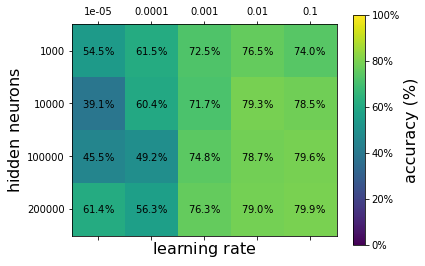

In [16]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()

use_cuda = not args.no_cuda and torch.cuda.is_available()

# set seed of random number generator
torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

grid_search(args, device)
